In [1]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

from stella.utils import flare_lightcurve

from utils import *

## PROPOSAL ID 16164
plt.rcParams['font.size']=24

rootname = ['lebb01s7q', 'lebb01sbq', 'lebb01sdq', 'lebb01siq', 'lebb01smq']

wavelength, flux, err = load_binned_data()
tab = load_table('ew.tab')
colors = load_inferno(len(tab.colnames)+2, 'inferno')[1:]
lines = load_lines()
parula = np.load('/Users/arcticfox/parula_colors.npy')

from pylab import cm
import matplotlib
cmap = cm.get_cmap('inferno', len(list(lines.keys()))+2)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)[1:-1]

In [2]:
tpeak = 12455.942687932402
oot = ((tab['orbits'] == 2) & (tab['time_s'] <= tpeak-20))
it = np.where((tab['orbits']==2) & (tab['time_s'] > tpeak-20))[0]
template = np.nanmedian(flux[oot,:], axis=0)

scaling = 10**11
residuals = np.zeros(flux[it,:].shape)
for i in tqdm_notebook(range(len(it))):
    residuals[i] = (flux[it[i]]*scaling) - (template*scaling)

## Comparing peak in all in-flare spectra to out-of-flare spectra

(0.0, 0.08355211723778788)

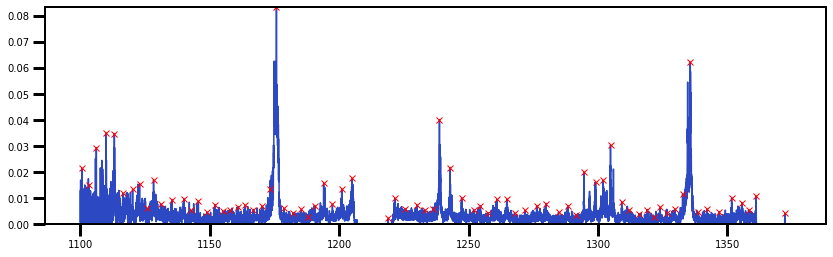

In [6]:
pc = np.load('/Users/arcticfox/parula_colors.npy')[np.linspace(0,210,len(flux),dtype=int)]
max_template = np.nanmax(flux[it,:], axis=0)
r = (max_template*scaling) - (template*scaling)
plt.figure(figsize=(14,4))
plt.plot(wavelength[wavelength>1100],
         r[wavelength>1100], c=pc[i])
peaks, _ = find_peaks(r[wavelength>1100], distance=150)
plt.plot(wavelength[wavelength>1100][peaks],
         r[wavelength>1100][peaks], 'rx')
plt.ylim(np.nanmin(r[wavelength>1100]),
         np.nanmax(r[wavelength>1100]))

## Plotting individual new lines

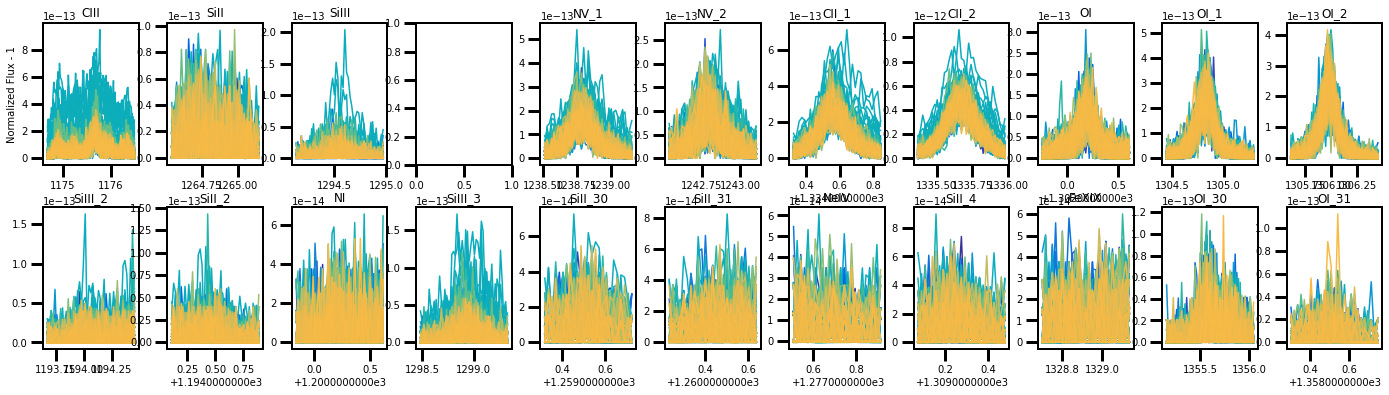

In [16]:
%matplotlib inline
keys = list(lines.keys())

fig, axes = plt.subplots(nrows=2, ncols=int(len(keys)/2), figsize=(24,6))
fig.set_facecolor('w')
k = 0
x = 0

widths = {}
width_errs = {}

for ax in axes.reshape(-1):
    try:
        v,_ = to_velocity(wavelength, mid=lines[keys[k]][0])
        reg = np.where((v.value>=lines[keys[k]][1]) & (v.value<=lines[keys[k]][2]))[0]
        EA = np.nansum(flux[:,reg], axis=1)

        widths[keys[k]] = EA
        width_errs[keys[k]] = np.nansum(err[:,reg], axis=1)/np.sqrt(len(reg))

        for i in range(len(flux)):
            if x < len(keys):
                ax.plot(wavelength[reg], flux[i][reg], c=pc[i])
                ax.set_title(keys[k])
                if x == 0:
                    ax.set_ylabel('Normalized Flux - 1')
            else:
                ax.plot(times[i], EA[i],'o', c=parula[orbits[i]])
                ax.set_xlabel('Time - 59362.14828 [s]')
                if x == 6:
                    ax.set_ylabel('EW')

        ax.set_rasterized(True)
    except:
        pass
    k += 1
    
    if k > len(keys)-1:
        k = 0
        
    x += 1
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#plt.savefig('lines.png', dpi=250, rasterize=True, bbox_inches='tight')

In [47]:
lines = {'CIII':[1175.59, -240, 230],
             'SiII':[1264.738, -50, 100],
             'SiIII':[1294.5480,-100,100], ## NEW                                                                                              
             #'SiIV':[1393.7570, -100, 100],
             'NV_1':[1238.831,-80,80],
             'NV_2':[1242.804,-70,70],
             'CII_10':[1334.532,-50,70], # edited                                                                                               
             'CII_11':[1335.708,-80,60], # edited                                                                                               
             'OI':[1302.1689,-50,50], ## NEW                                                                                                 
             'OI_10':[1304.8580,-60,50], ## NEW                                                                                                
             'OI_11':[1306.0291,-60,50], ## NEW                                                                                                
             'SiIII_2':[1194.0490,-100,100], ## NEW                                                                                             
             'SiII_2':[1194.5000,-100,100], ## NEW                                                                                             
             'NI':[1200.2260,-50,50], ## NEW                                                                                                   
             'SiIII_3':[1200.9611,-30,50], ## NEW                                                                                             
             'SiII_30':[1259.5210,-50,50], ## NEW                                                                                               
             'SiII_31':[1260.4220,-50,50], ## NEW                                                                                              
             'NeIV':[1277.7045,-50,50], ## NEW                                                                                                 
             'SiIII_4':[1298.8940,-100,100], ## NEW                                                                                             
             'SiII_4':[1309.2760,-50,50], ## NEW                                                                                                
             'FeXIX':[1328.9061,-50,50], ## NEW                                                                                                 
             'OI_30':[1355.5980,-100,100], ## NEW                                                                                               
             'OI_31':[1358.5120,-50,50]
             }

## Playing with different velocity ranges

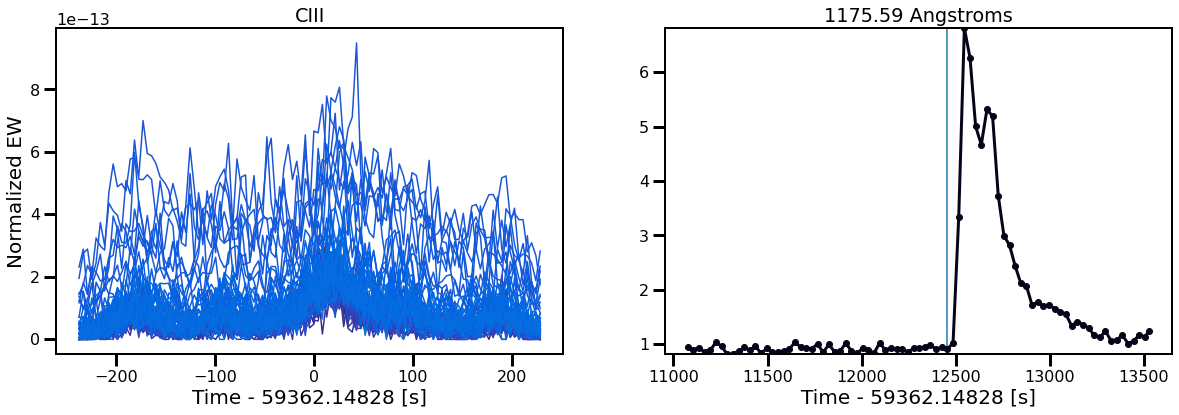

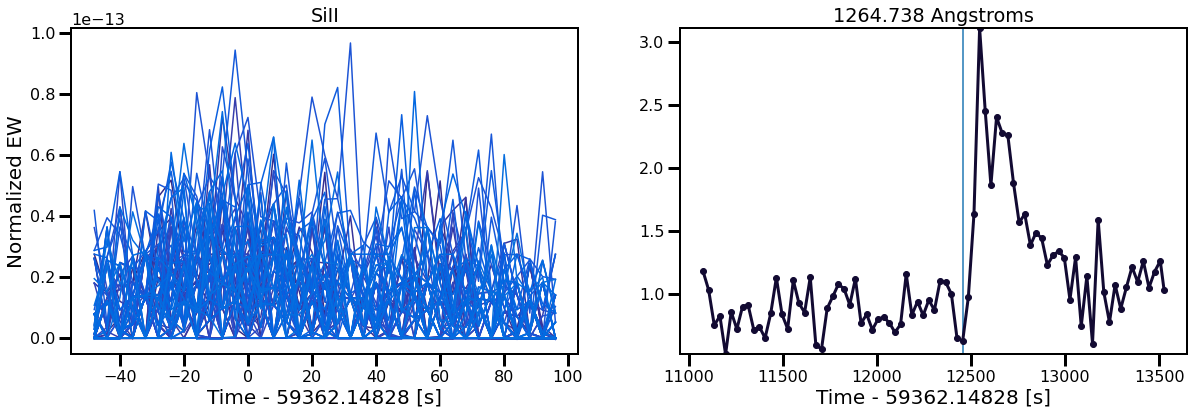

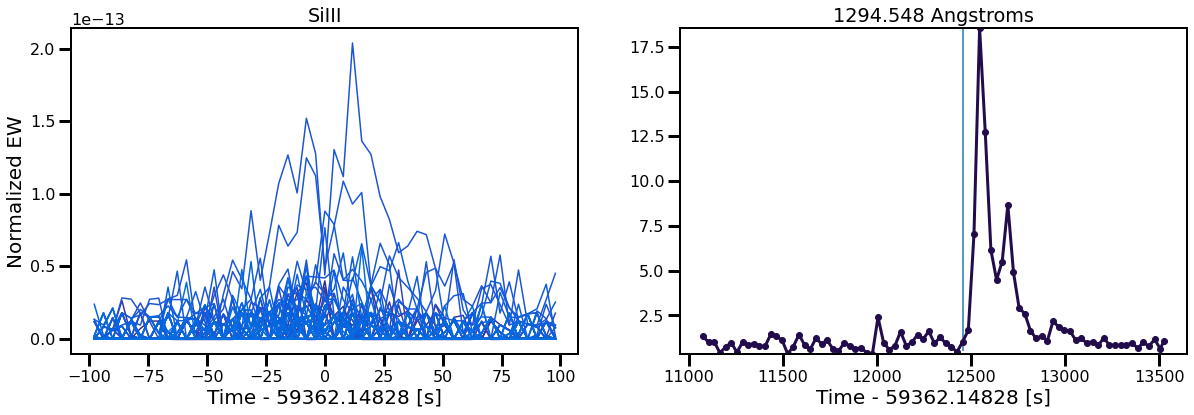

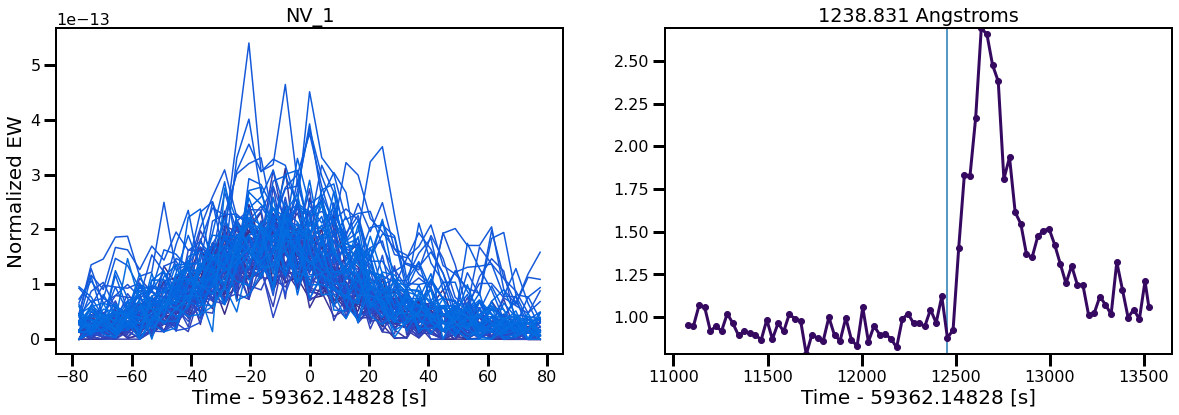

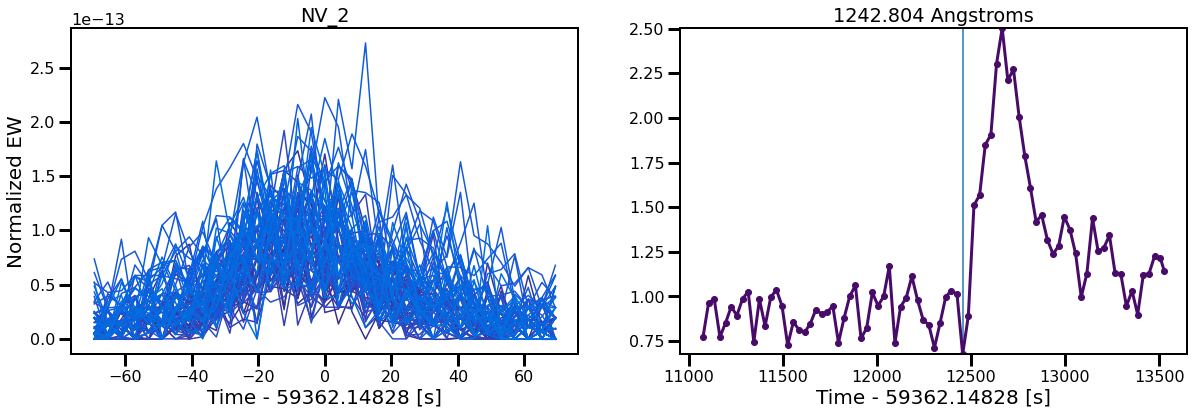

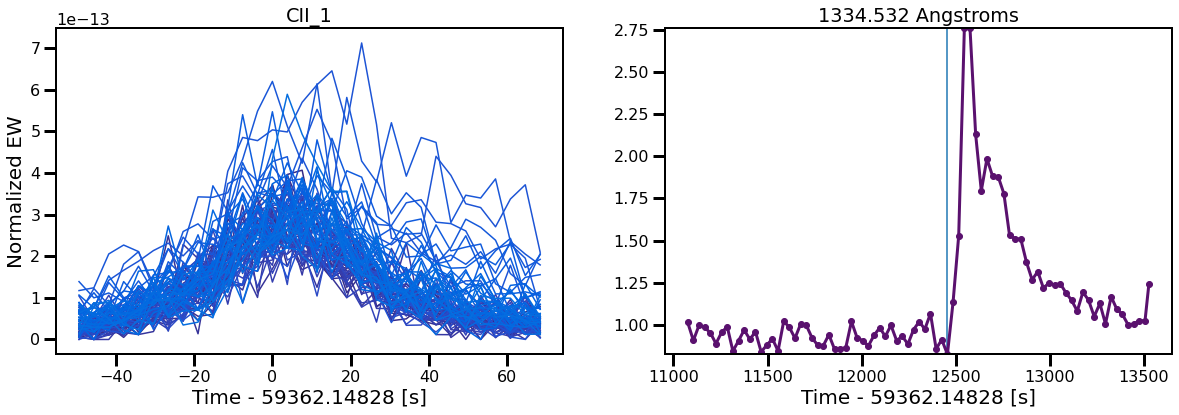

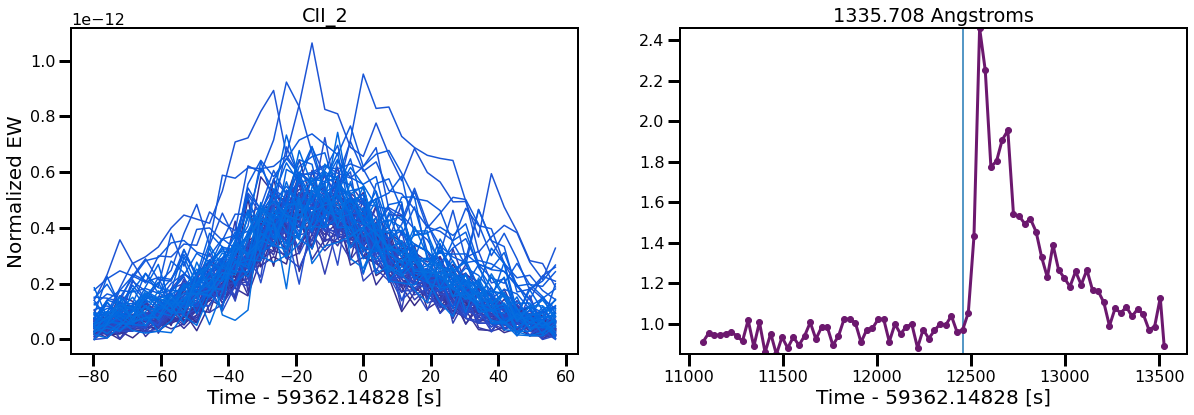

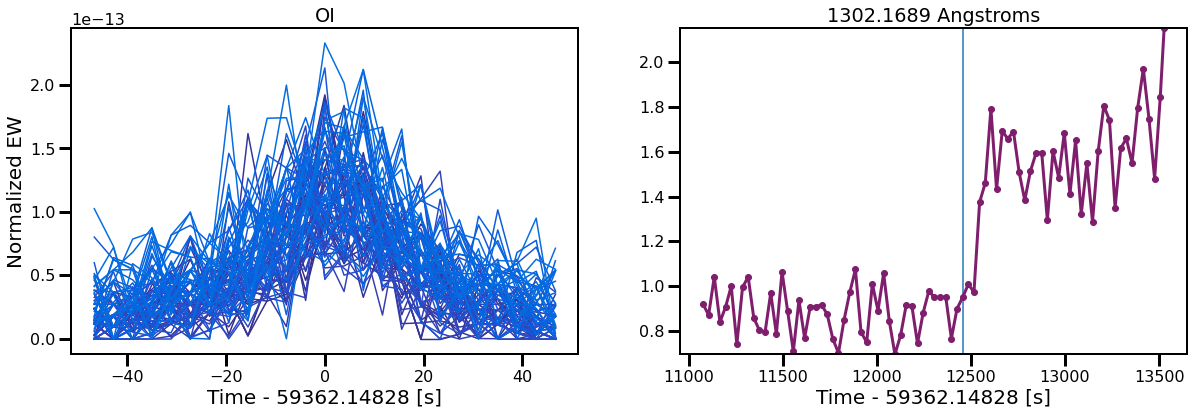

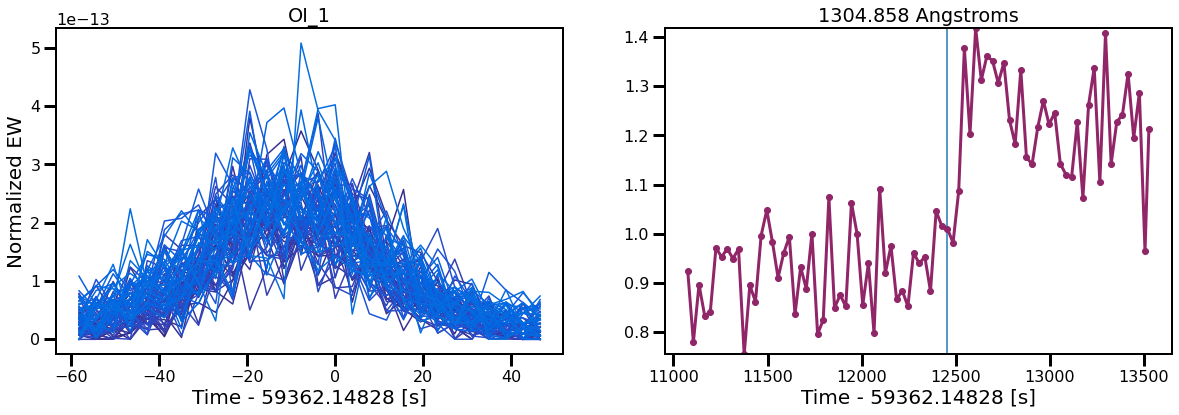

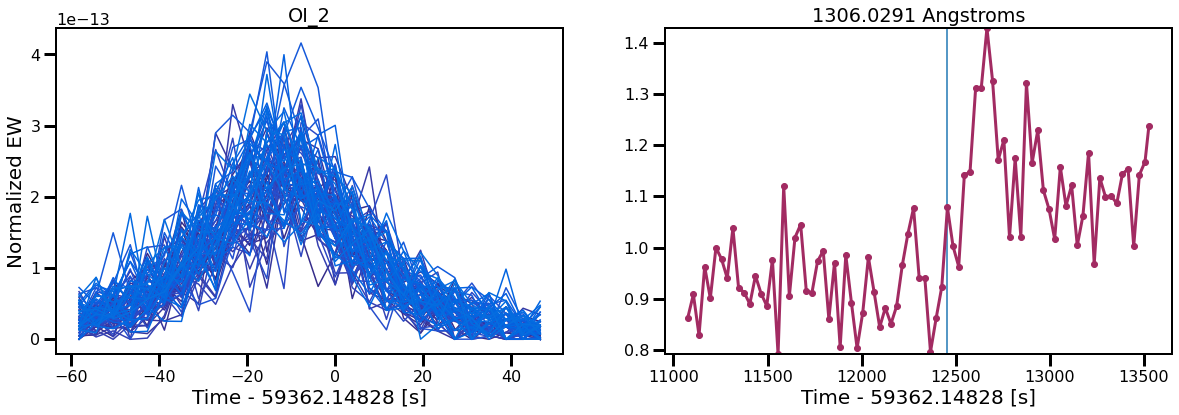

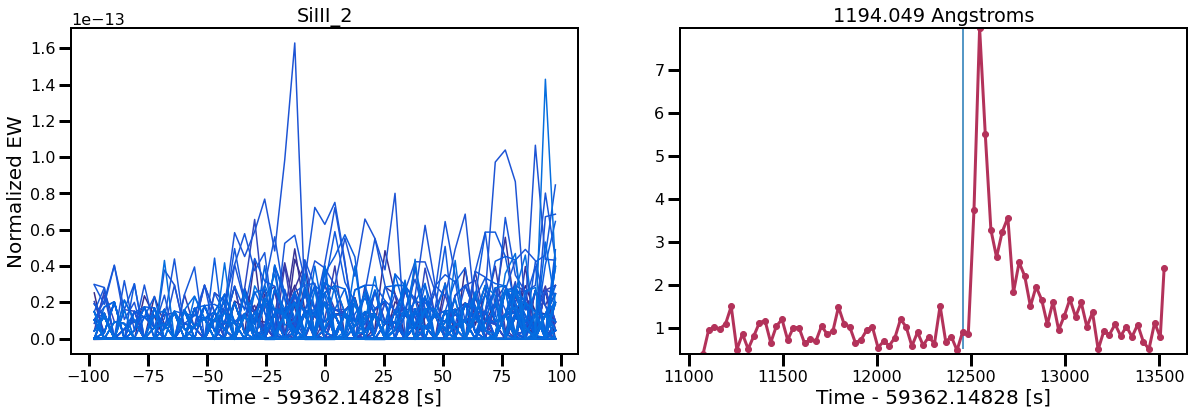

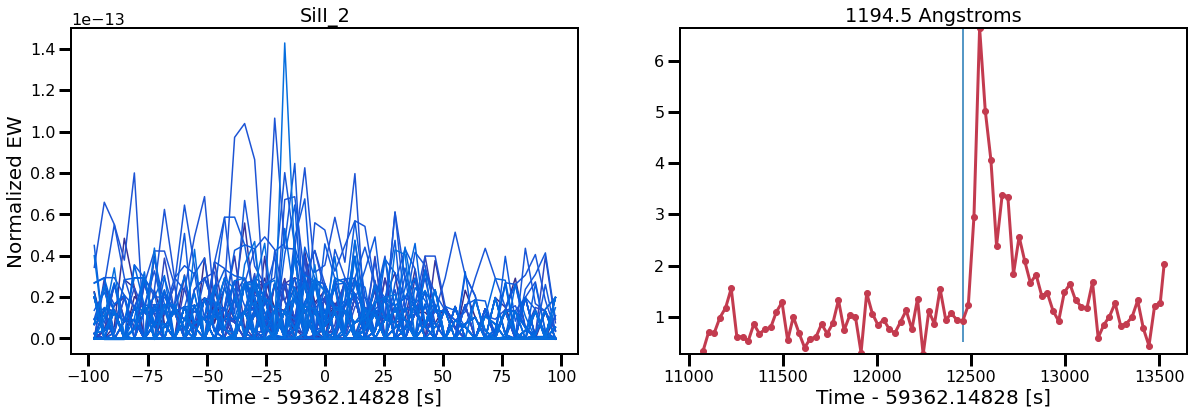

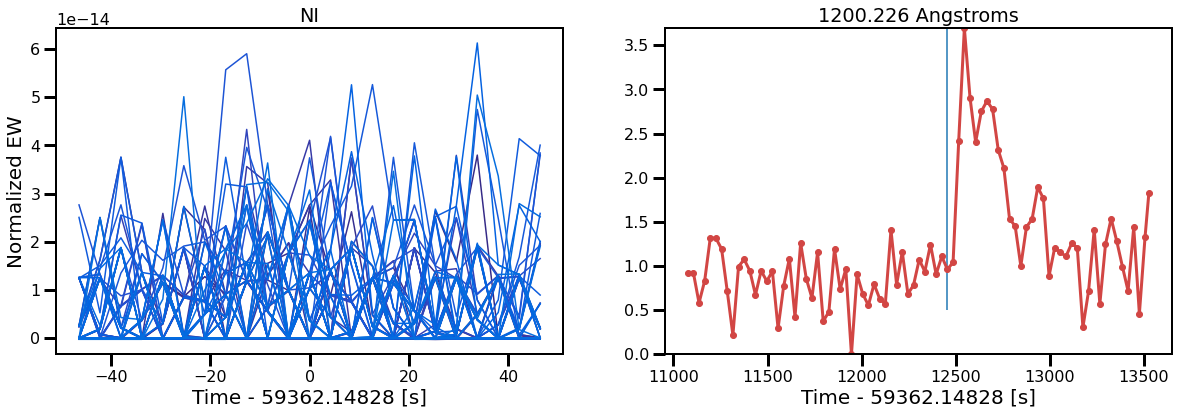

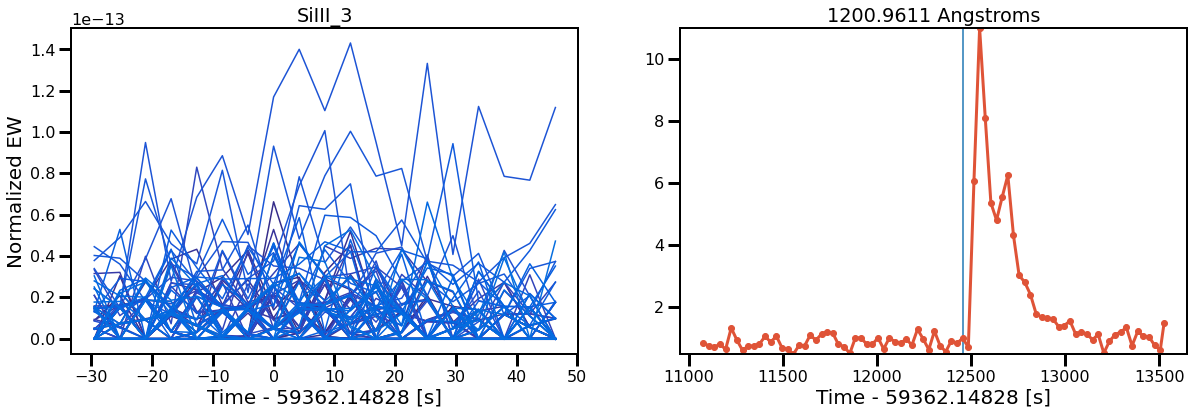

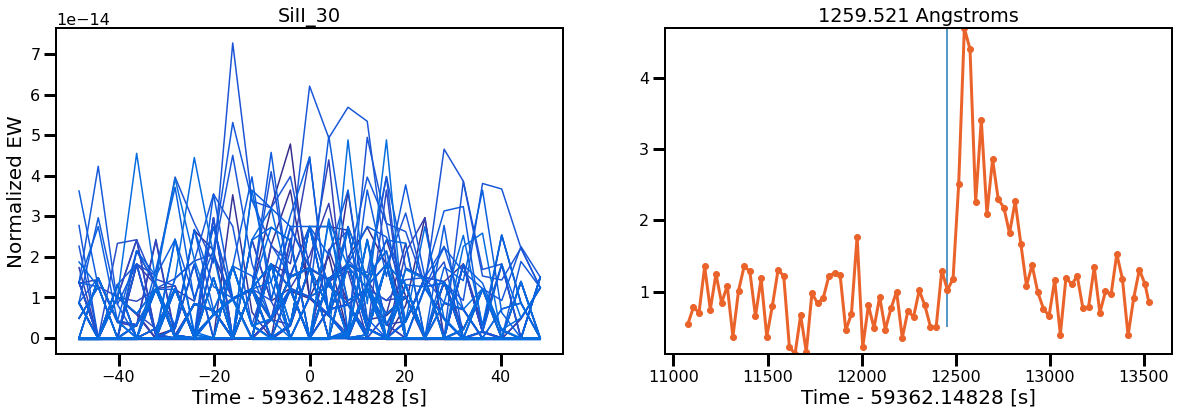

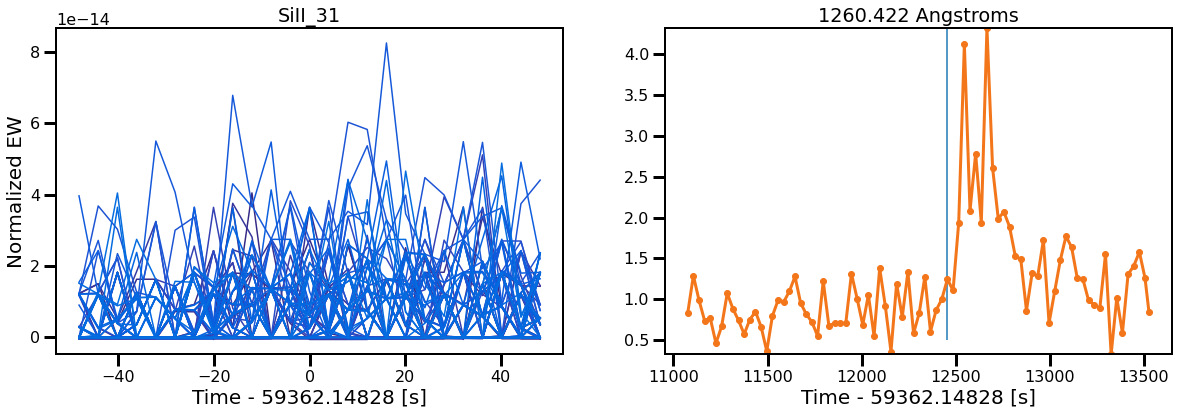

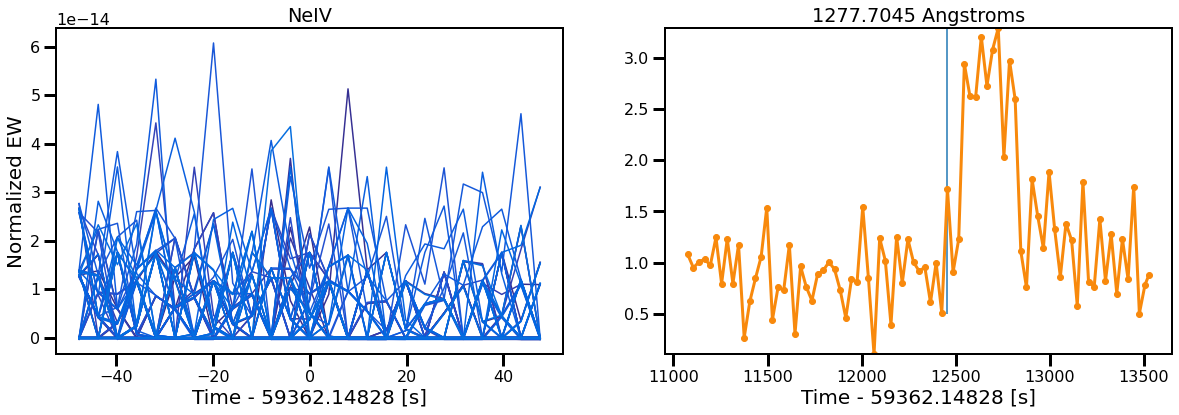

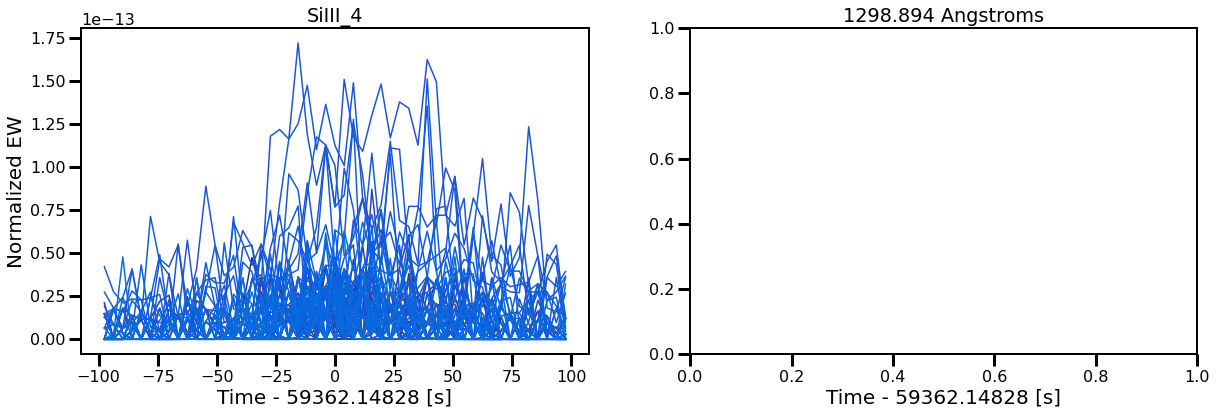

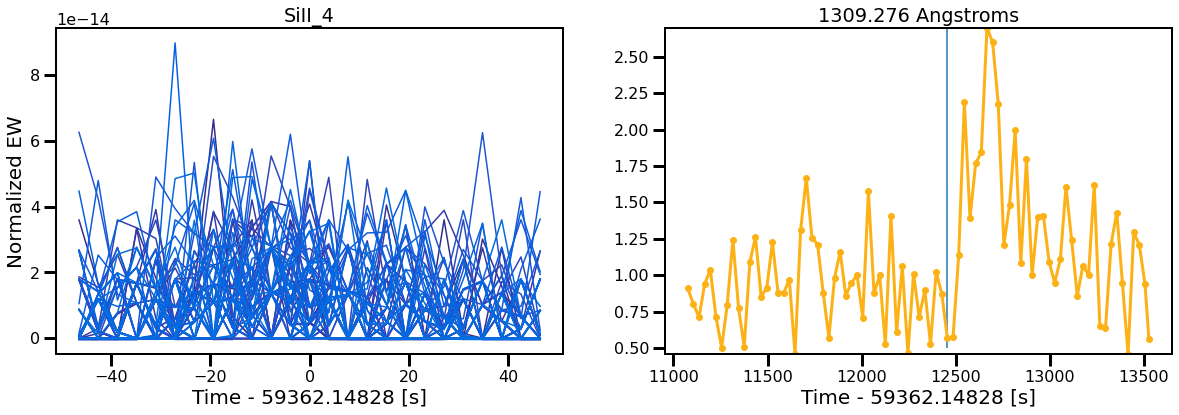

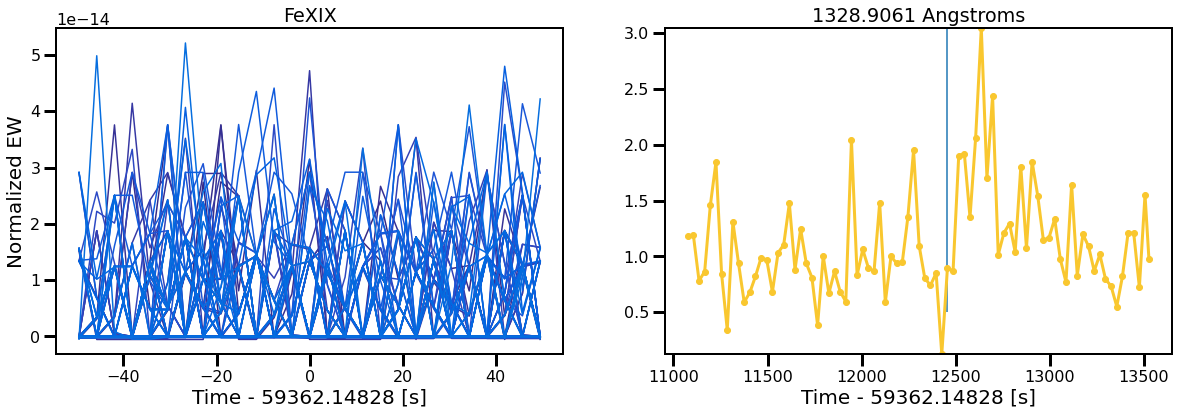

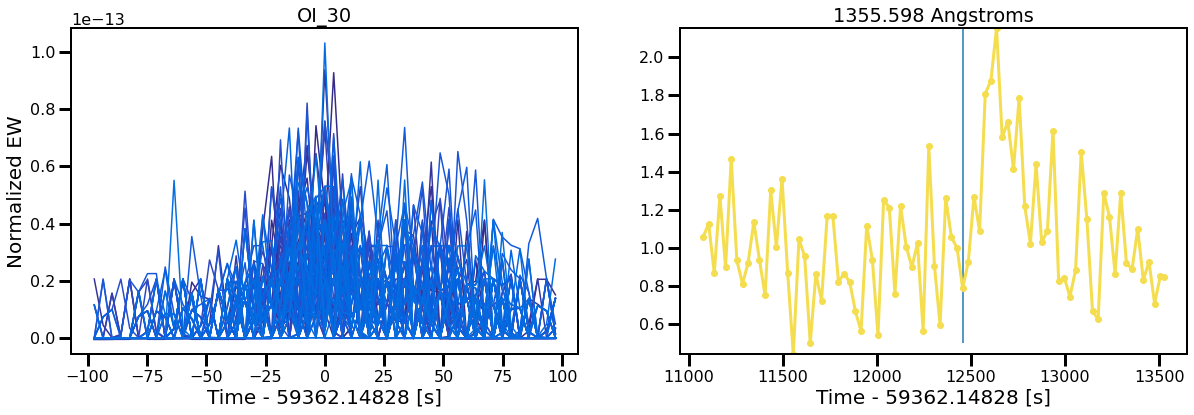

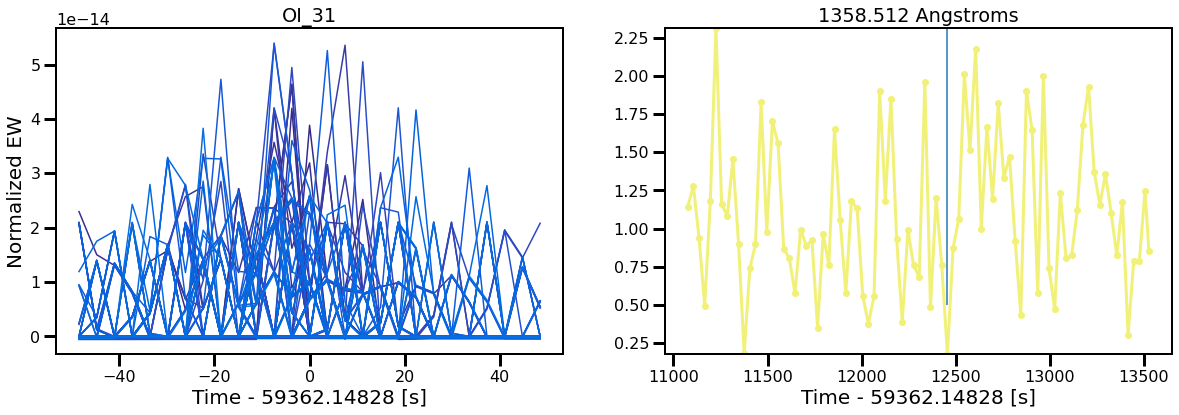

In [46]:
plt.rcParams['font.size'] = 16
keys = list(lines.keys())
shapes = ['o', 's', '*', '^', '.', '<']

for k in range(len(keys)):
    
    fig, (ax1,ax2) = plt.subplots(figsize=(20,6), ncols=2, nrows=1)
    fig.set_facecolor('w')
    ax1.set_title(keys[k])
    ax2.set_title('{} Angstroms'.format(lines[keys[k]][0]))
    q = tab['orbits'] == 2

    try:
        w = widths[keys[k]][q]*10**12
        ax2.plot(tab['time_s'][q],
                w/np.nanmedian(w),
                c=colors[k], lw=3)
        ax2.errorbar(tab['time_s'][q],
                    w/np.nanmedian(w),
                    c=colors[k], marker='o', 
                    linestyle='')
        ax2.vlines(tpeak,0.5,100)
        ax2.set_ylim(np.nanmin(w/np.nanmedian(w)),
                     np.nanmax(w/np.nanmedian(w)))
    except KeyError:
        pass
    
    v,_ = to_velocity(wavelength, mid=lines[keys[k]][0])
    reg = np.where((v.value>=lines[keys[k]][1]) & (v.value<=lines[keys[k]][2]))[0]
    for i in range(len(flux[q,:])):
        ax1.plot(v[reg], flux[q][i][reg], c=pc[i])

    ax1.set_xlabel('Time - 59362.14828 [s]', fontsize=20)
    ax2.set_xlabel('Time - 59362.14828 [s]', fontsize=20)
    ax1.set_ylabel('Normalized EW', fontsize=20)
    plt.show()
    


#plt.savefig('flare.png', dpi=250, rasterize=True, bbox_inches='tight')

## Looking at the light curves

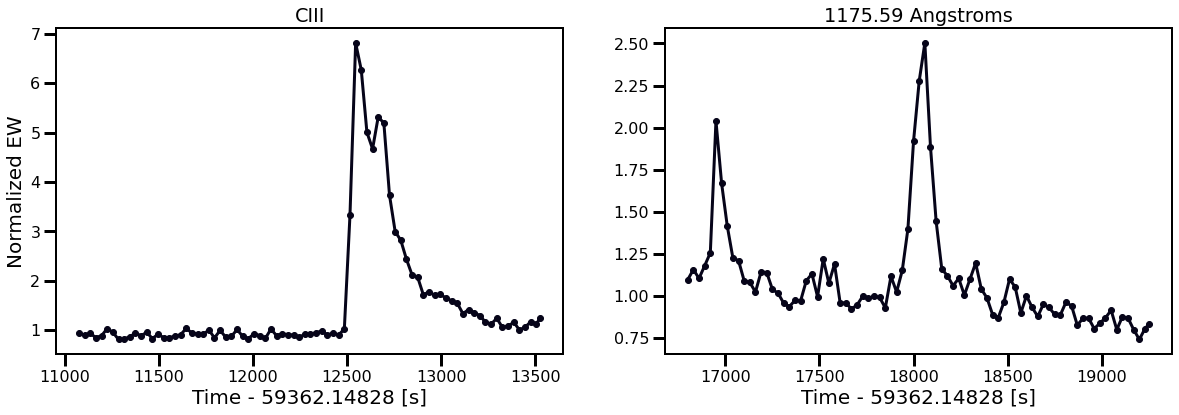

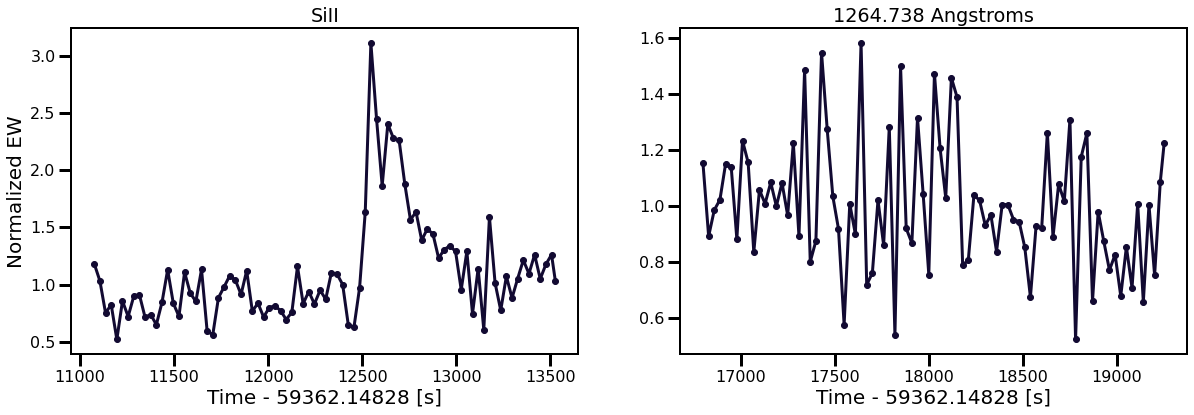

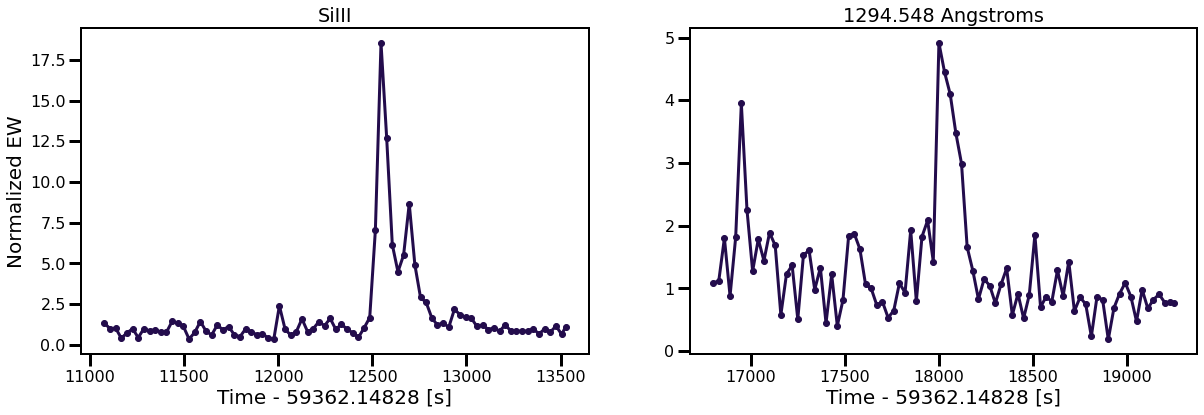

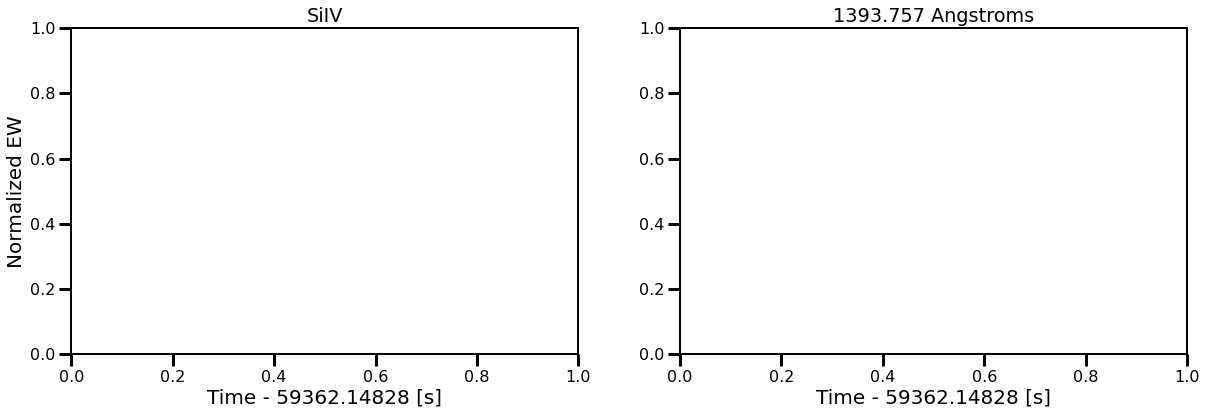

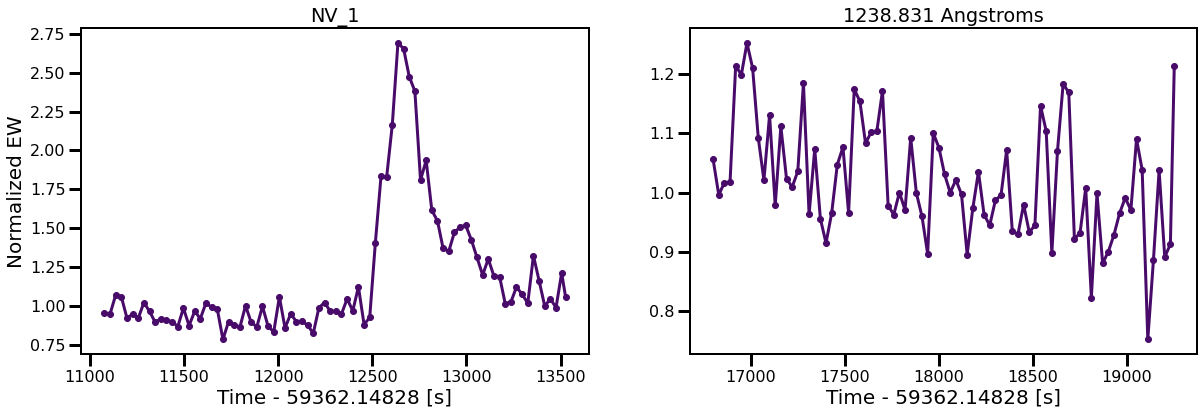

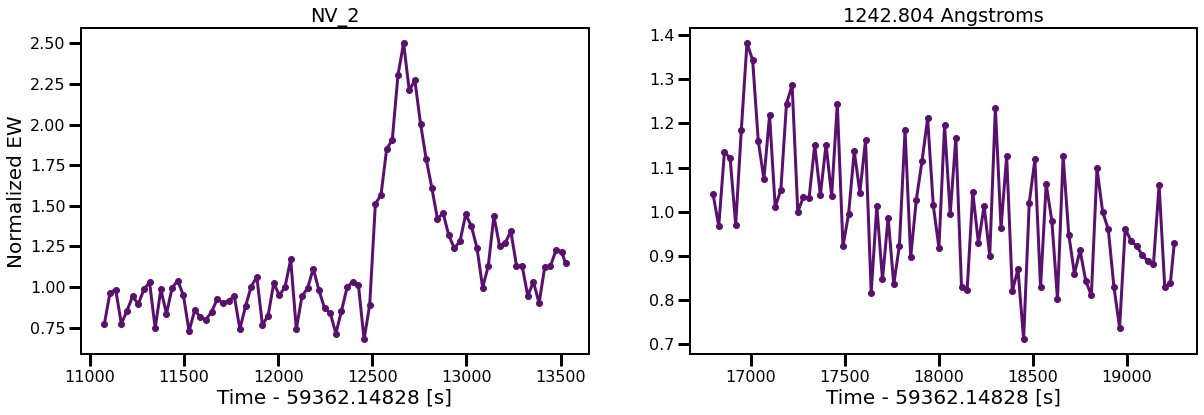

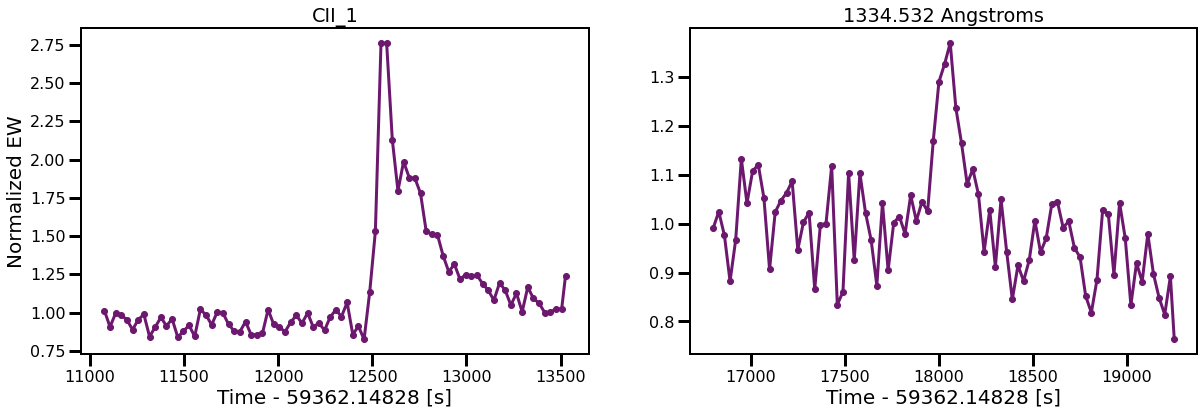

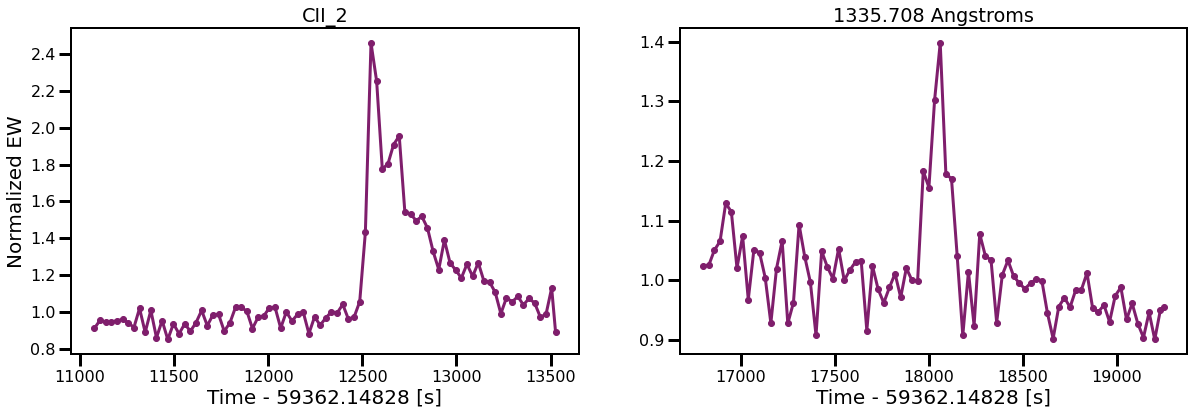

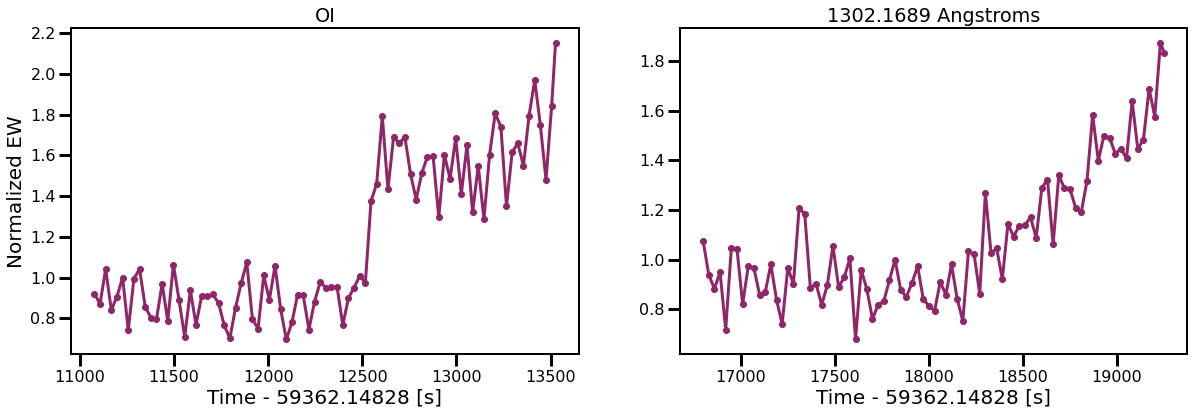

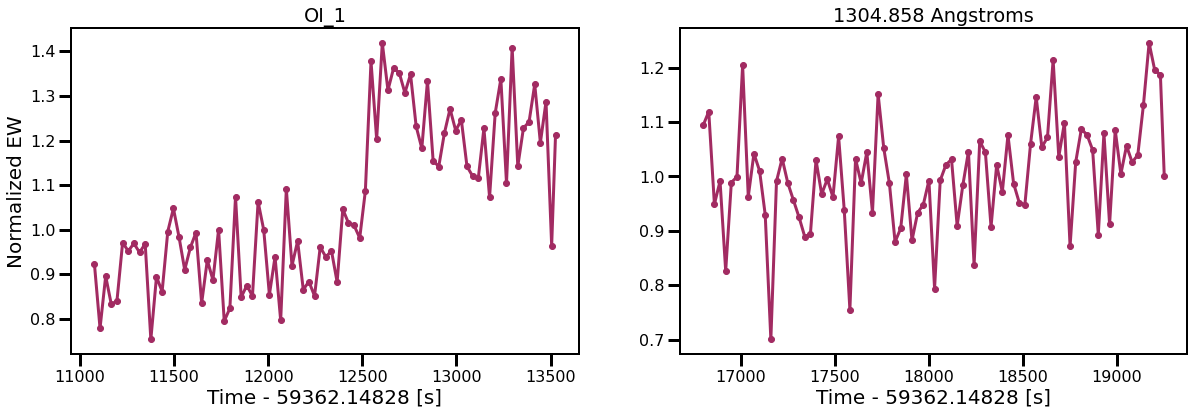

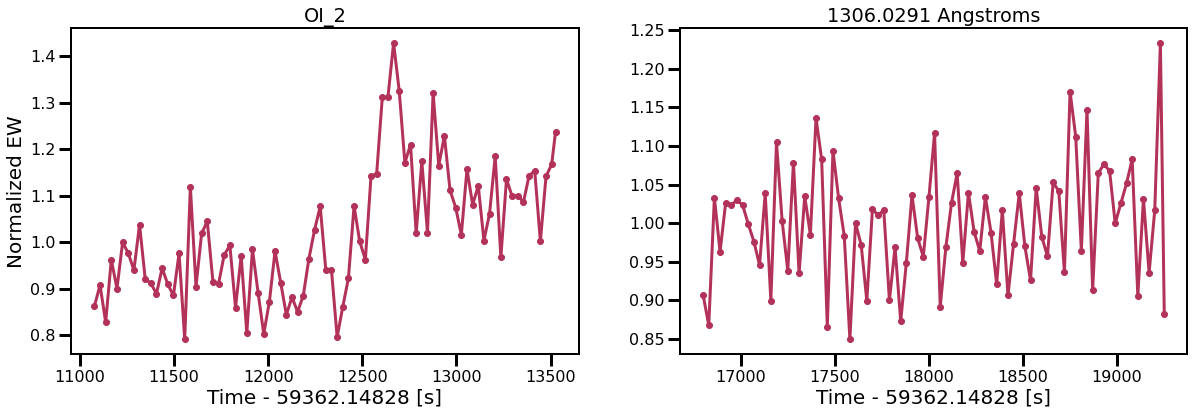

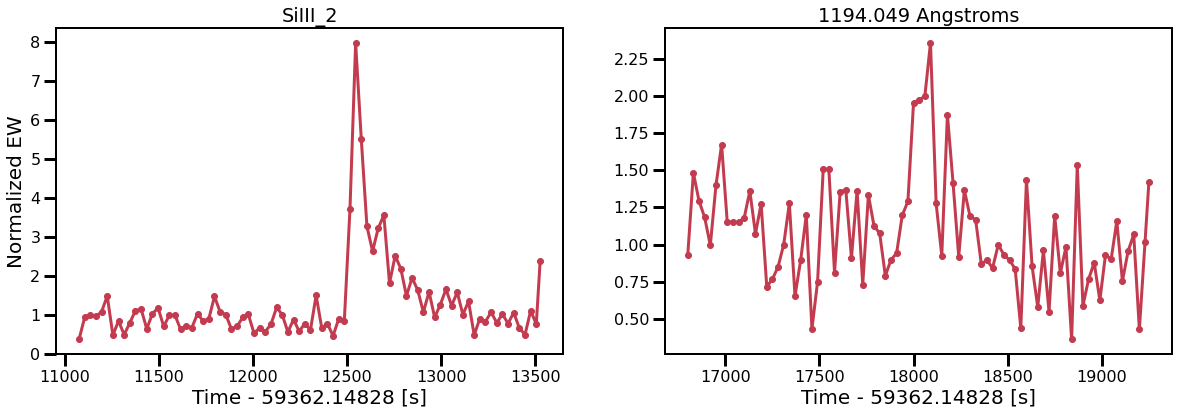

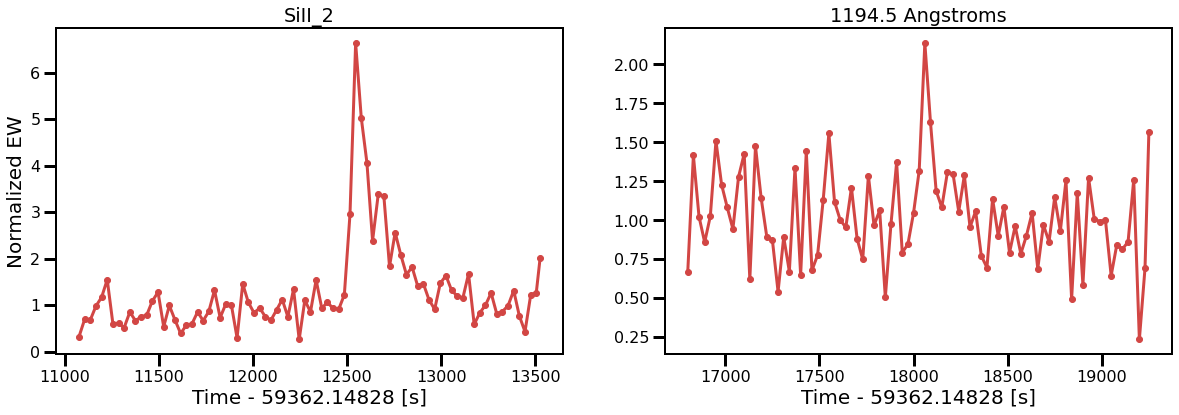

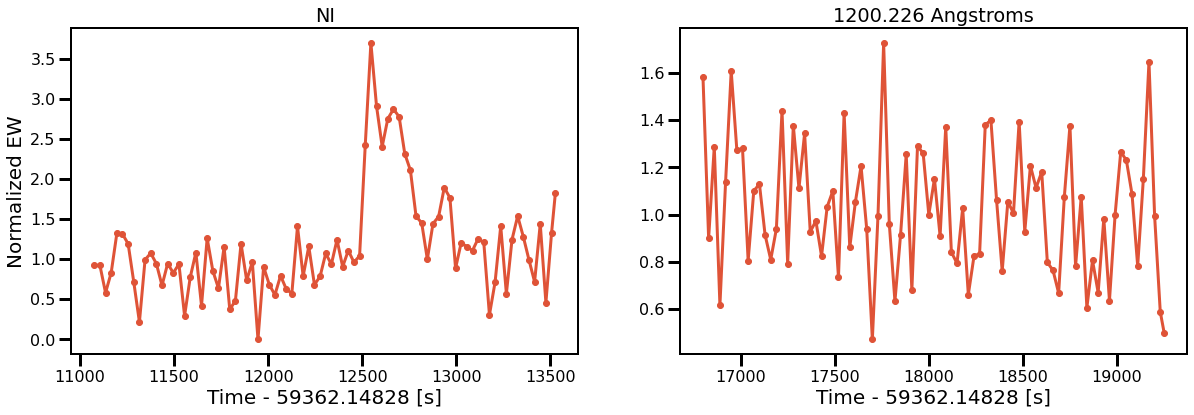

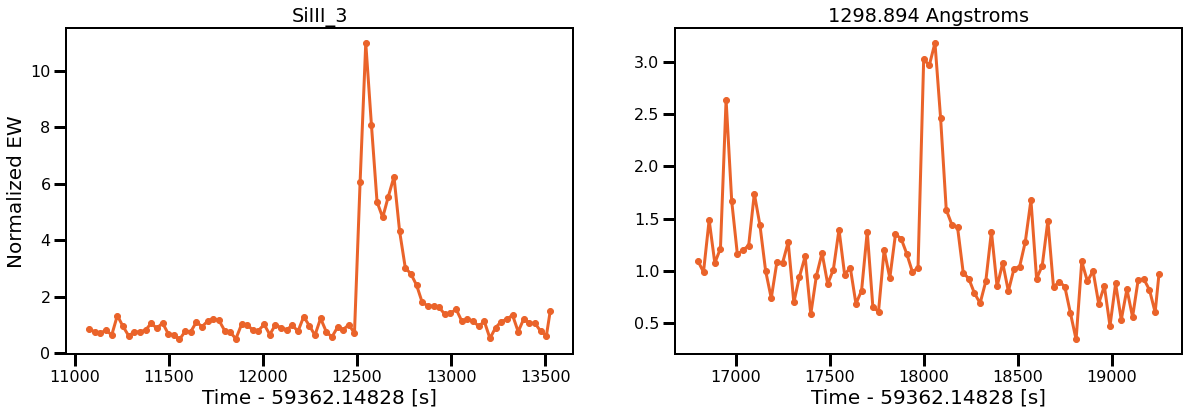

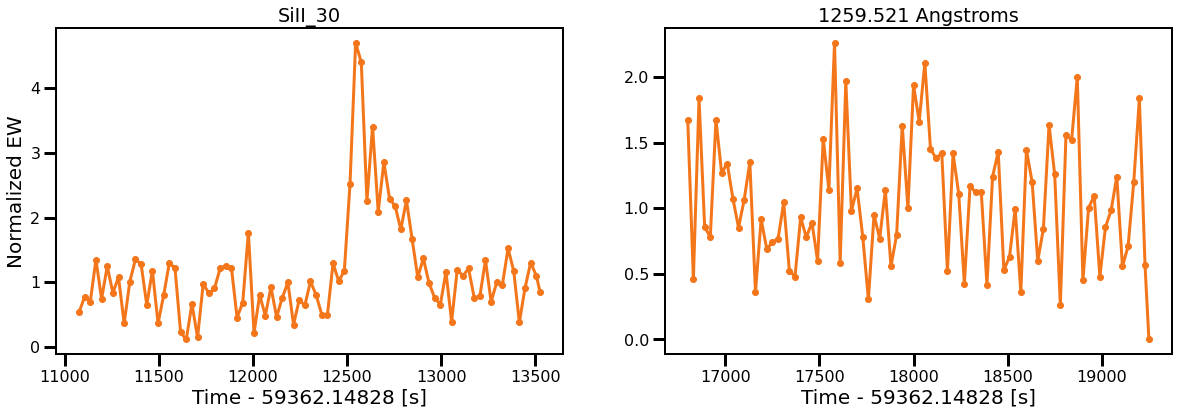

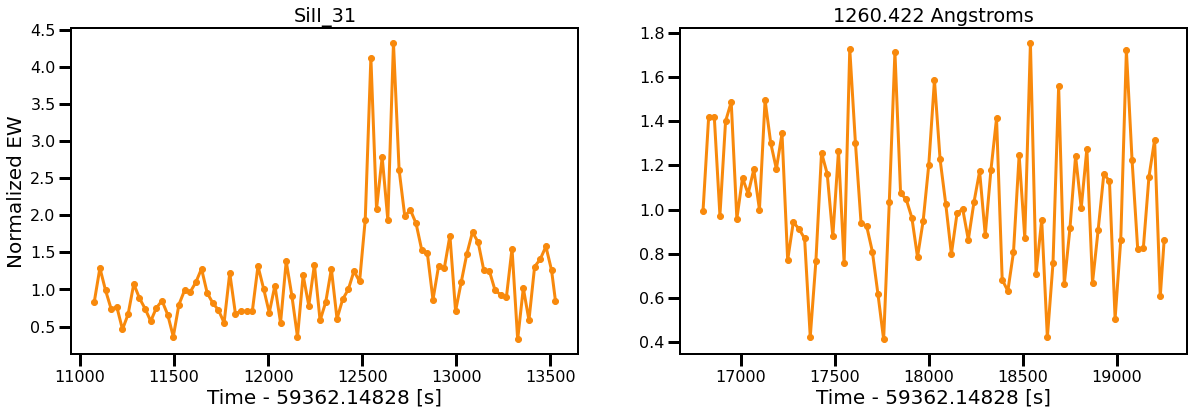

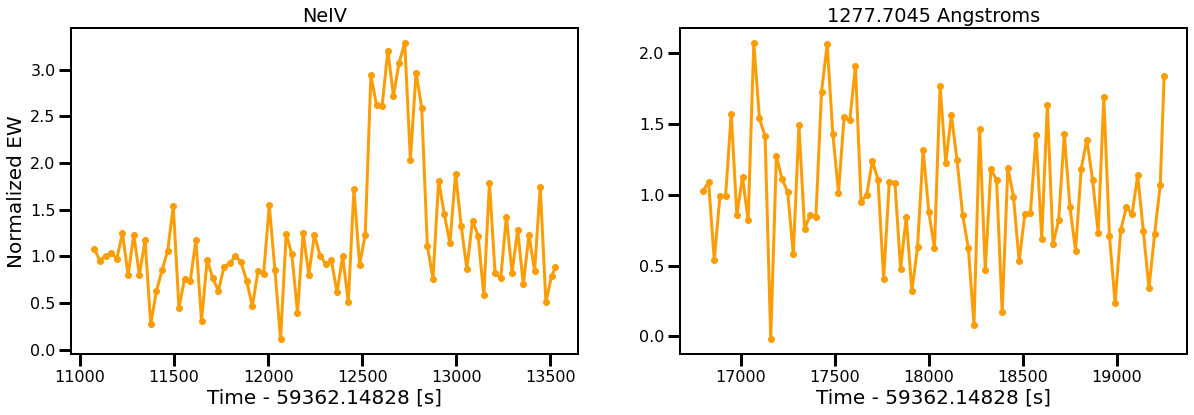

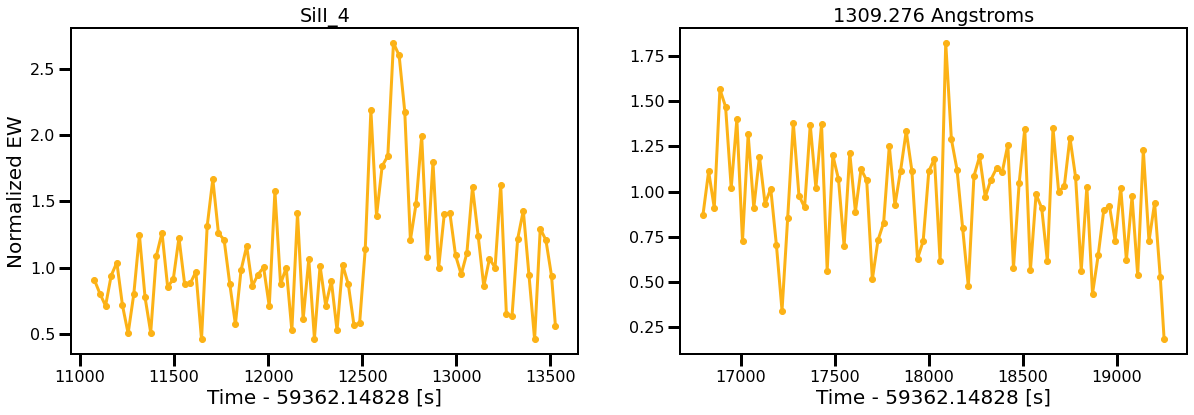

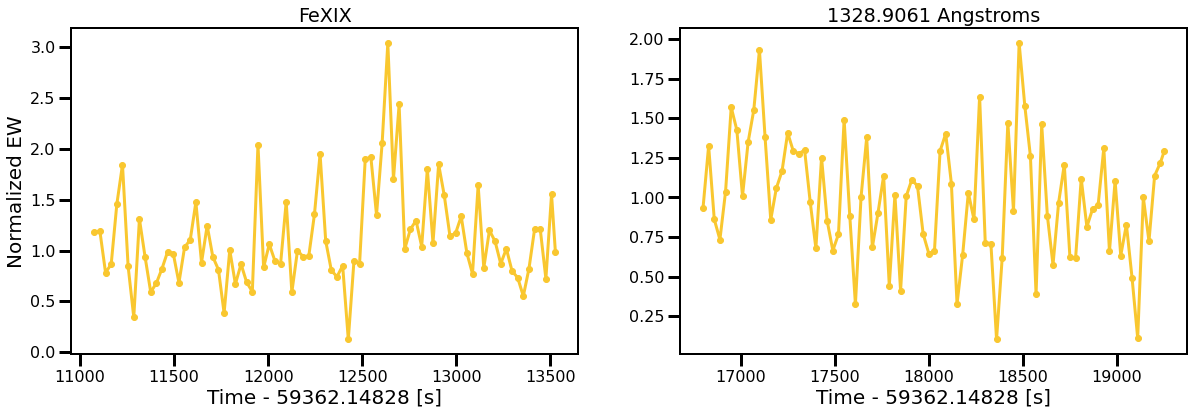

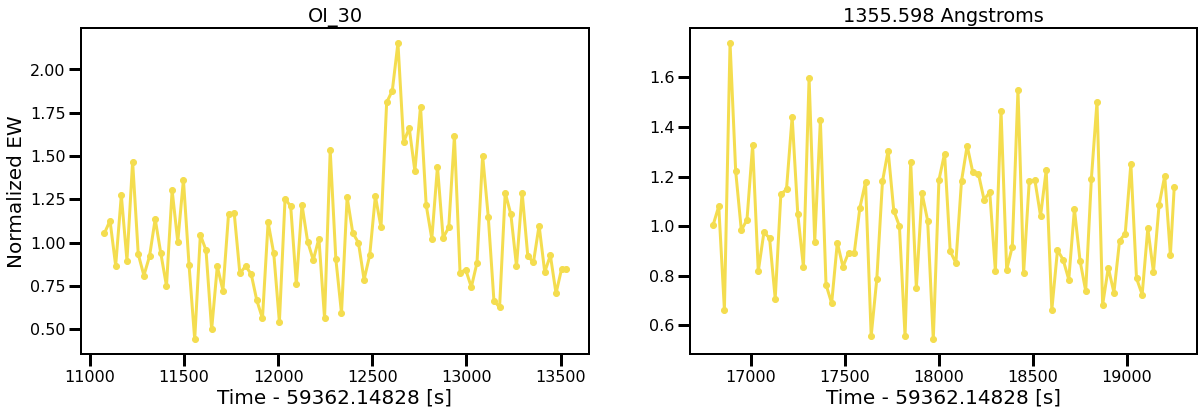

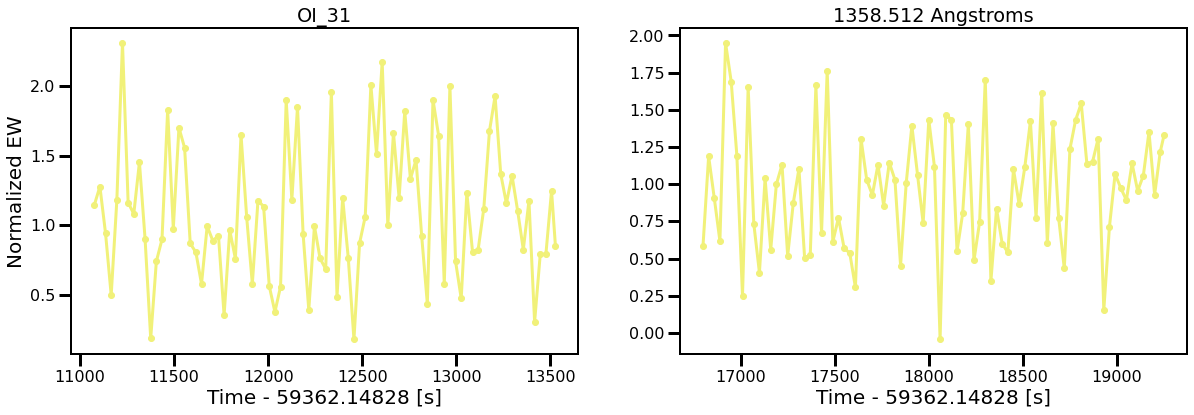

In [30]:
plt.rcParams['font.size'] = 16
keys = list(lines.keys())
shapes = ['o', 's', '*', '^', '.', '<']



for k in range(len(keys)):
    
    fig, (ax1,ax2) = plt.subplots(figsize=(20,6), ncols=2, nrows=1)
    fig.set_facecolor('w')
    ax1.set_title(keys[k])
    ax2.set_title('{} Angstroms'.format(lines[keys[k]][0]))
    
    for o in [2,3]:
        q = tab['orbits'] == o
        if o == 2:
            ax = ax1
        else:
            ax = ax2
        try:
            w = widths[keys[k]][q]*10**12
            ax.plot(tab['time_s'][q],
                    w/np.nanmedian(w),
                    c=colors[k], lw=3)
            ax.errorbar(tab['time_s'][q],
                        w/np.nanmedian(w),
                        c=colors[k], marker='o', 
                        linestyle='')
        except KeyError:
            pass

    ax1.set_xlabel('Time - 59362.14828 [s]', fontsize=20)
    ax2.set_xlabel('Time - 59362.14828 [s]', fontsize=20)
    ax1.set_ylabel('Normalized EW', fontsize=20)
    plt.show()
    


#plt.savefig('flare.png', dpi=250, rasterize=True, bbox_inches='tight')